In [40]:
import os, sys, random, pandas as pd, numpy as np
from tqdm import tqdm
import torch


# set random seed
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
SEED = 10
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)
sys.path.append('../')


# load package requirments
from VGFM.utils import  generate_steps, parser, _valid_criterions
from VGFM.plots import plot_comparision
from VGFM.train import pretrain, train
from VGFM.models import  FNet, ODEFunc2
from VGFM.constants import DATA_DIR
from VGFM.exp import setup_exp
from VGFM.eval import generate_plot_data
from torchdiffeq import odeint_adjoint as odeint

### Defining parameters and loading dataset

In [41]:
import torch.optim as optim

dim=5
f_net = FNet(in_out_dim=dim, hidden_dim=128, n_hiddens=3, activation='leakyrelu')

import sys

# Simulate the command-line arguments
sys.argv = [
    'VGFM Training',
    '-d', 'file',
    '-c', 'ot1',
    '-n', 'eb5_ho2',
    '--hold-one-out',
    '-ho', '2',
    '-e1', '2000',
    '-e2', '30',
    '-bs', '256',
    '-r', '0.01',
    '-rm', '5',
    '--norm_cost'
]

args = parser.parse_args()
opts = vars(args)

# Display the parsed arguments
print(opts)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


{'dataset': 'file', 'time_col': None, 'name': 'eb5_ho2', 'output_dir': 'd:\\NeurIPS_2025_VGFM\\VGFM\\results', 'criterion': 'ot1', 'sample_with_replacement': False, 'hold_one_out': True, 'hold_out': 2, 'apply_losses_in_time': True, 'learning_rate1': 0.001, 'epochs1': 2000, 'norm_cost': True, 'reg': 0.01, 'reg_m': 5.0, 'n_big_batches': 1, 'n_batch': 256, 'learning_rate2': 0.0001, 'epochs2': 30}


device(type='cpu')

In [42]:
df = pd.read_csv(DATA_DIR + '/eb_pca50.csv')
df=df.iloc[:,:dim+1]
 # make output dir
if not os.path.isdir(opts['output_dir']):
    os.makedirs(opts['output_dir'])
exp_dir, logger = setup_exp(opts['output_dir'], opts, opts['name'])
  # load dataset
logger.info(f'Loading dataset: '+opts['name'])


from sklearn.preprocessing import StandardScaler
import pandas as pd

cols_to_scale = [c for c in df.columns if c != "samples"]

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
df = df_scaled


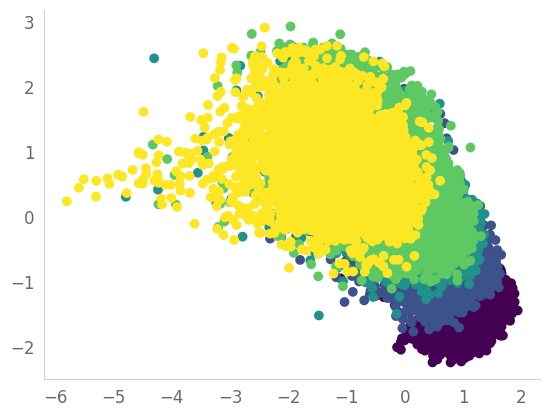

In [43]:
import matplotlib.pyplot as plt
plt.scatter(df.iloc[:,1],df.iloc[:,2],c=df.iloc[:,0])

In [44]:
args.hold_out

2

In [45]:
groups = sorted([g for g in df.samples.unique() if g != args.hold_out])
steps = generate_steps(groups)
optimizer = torch.optim.Adam(f_net.parameters())
opts['criterion']='ot1'
criterion =  _valid_criterions[opts['criterion']]()

# # logger.info(f'Extracting parameters')
use_cuda = torch.cuda.is_available()
# sample_with_replacement = opts['sample_with_replacement' ]
# apply_losses_in_time = opts['apply_losses_in_time']

    
local_losses = {f'{t0}:{t1}':[] for (t0, t1) in steps}
batch_losses = []
globe_losses = []

In [46]:
f_net=f_net.to(device)

In [47]:
initial_size=df[df['samples']==0].x1.shape[0]
initial_size

2381

In [48]:
sample_sizes = df.groupby('samples').size()
ref0 = sample_sizes / sample_sizes.iloc[0]  
relative_mass = torch.tensor(ref0.values) 
relative_mass

tensor([1.0000, 1.7484, 1.3767, 1.5393, 1.3994], dtype=torch.float64)

In [49]:
sample_size = (df[df['samples']==0.0].values.shape[0],)

### Training with $\mathcal{L}_{\rm VGFM}$

In [50]:
f_net, v_losses, g_losses, losses = pretrain(
    f_net,
    df,
    optimizer,
    n_epoch=args.epochs1,
    hold_out=args.hold_out,
    logger=logger,
    relative_mass=relative_mass,
    reg=args.reg,
    reg_m=[args.reg_m, np.inf],
    norm_cost=args.norm_cost,
    batch_size=args.n_batch
)


relative_mass tensor([1.0000, 1.7484, 1.3767, 1.5393, 1.3994], dtype=torch.float64)
t_train: [0, 1, 3, 4]


Begin flow and growth matching...: 100%|██████████| 2000/2000 [02:19<00:00, 14.35epoch/s, loss=0.182419, vloss=0.182402, gloss=0.000018]


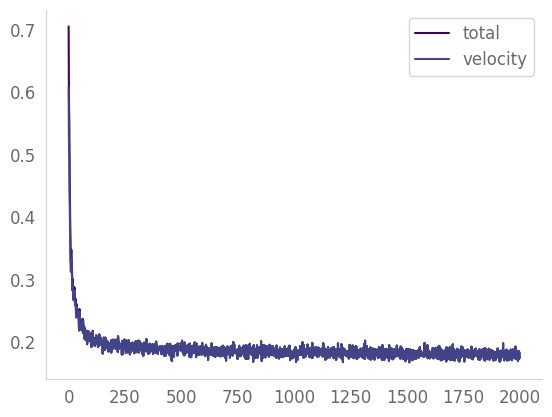

In [51]:
import matplotlib.pyplot as plt
plt.plot(losses,label='total')
plt.plot(v_losses,label='velocity')
# plt.plot(g_losses,label='growth')
plt.legend()

In [52]:
torch.save(f_net.state_dict(), os.path.join(exp_dir+'/pretrain_best_model'))

In [53]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/pretrain_best_model'),map_location=torch.device('cpu')))
optimizer = torch.optim.Adam(f_net.parameters(),lr=args.learning_rate2)

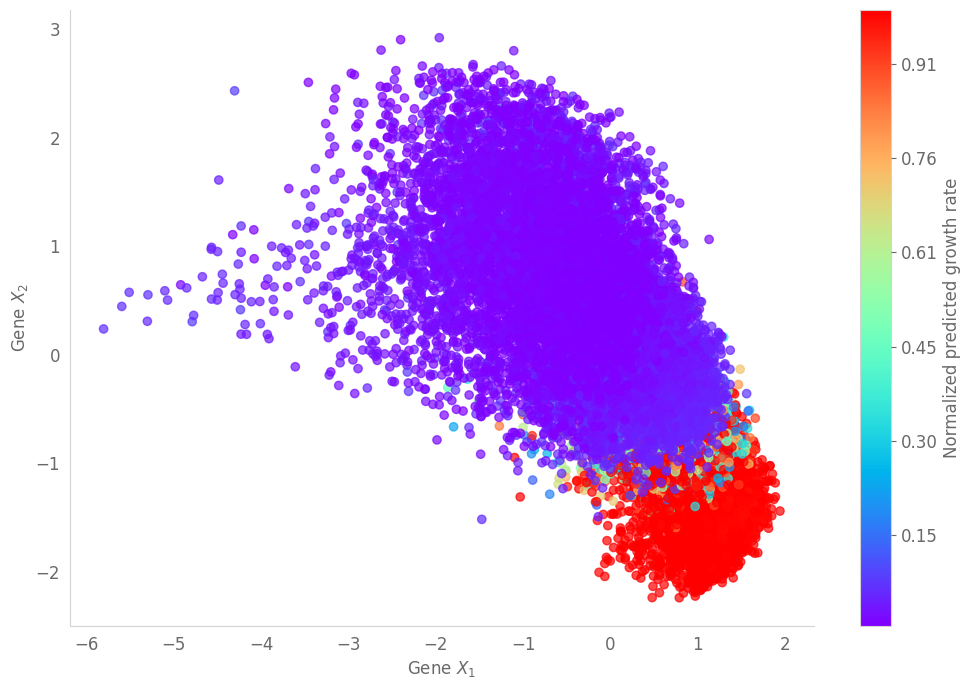

In [54]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        n = 5

        column_names = [f'x{i}' for i in range(1, n + 1)]

        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]

        data = torch.stack(tensors, dim=1)
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 90)
    vmin_value = np.percentile(all_g_values, 10)
    
    norm = plt.Normalize(vmin=vmin_value, vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_pretrain.pdf')

In [55]:
# generate plot data
f_net.to('cpu')
generated, trajectories,_,_ = generate_plot_data(
    f_net, df, n_points=400, n_trajectories=50, n_bins=100, 
    sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1., 2., 3., 4.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0404, 0.0808, 0.1212, 0.1616, 0.2020, 0.2424, 0.2828, 0.3232,
        0.3636, 0.4040, 0.4444, 0.4848, 0.5253, 0.5657, 0.6061, 0.6465, 0.6869,
        0.7273, 0.7677, 0.8081, 0.8485, 0.8889, 0.9293, 0.9697, 1.0101, 1.0505,
        1.0909, 1.1313, 1.1717, 1.2121, 1.2525, 1.2929, 1.3333, 1.3737, 1.4141,
        1.4545, 1.4949, 1.5354, 1.5758, 1.6162, 1.6566, 1.6970, 1.7374, 1.7778,
        1.8182, 1.8586, 1.8990, 1.9394, 1.9798, 2.0202, 2.0606, 2.1010, 2.1414,
        2.1818, 2.2222, 2.2626, 2.3030, 2.3434, 2.3838, 2.4242, 2.4646, 2.5051,
        2.5455, 2.5859, 2.6263, 2.6667, 2.7071, 2.7475, 2.7879, 2.8283, 2.8687,
        2.9091, 2.9495, 2.9899, 3.0303, 3.0707, 3.1111, 3.1515, 3.1919, 3.2323,
        3.2727, 3.3131, 3.3535, 3.3939, 3.4343, 3.4747, 3.5152, 3.5556, 3.5960,
        3.6364, 3.6768, 3.7172, 3.7576, 3.7980, 3.8384, 3.8788, 3.9192, 3.9596,
        4.0000])
<class 'torch.Tensor'>


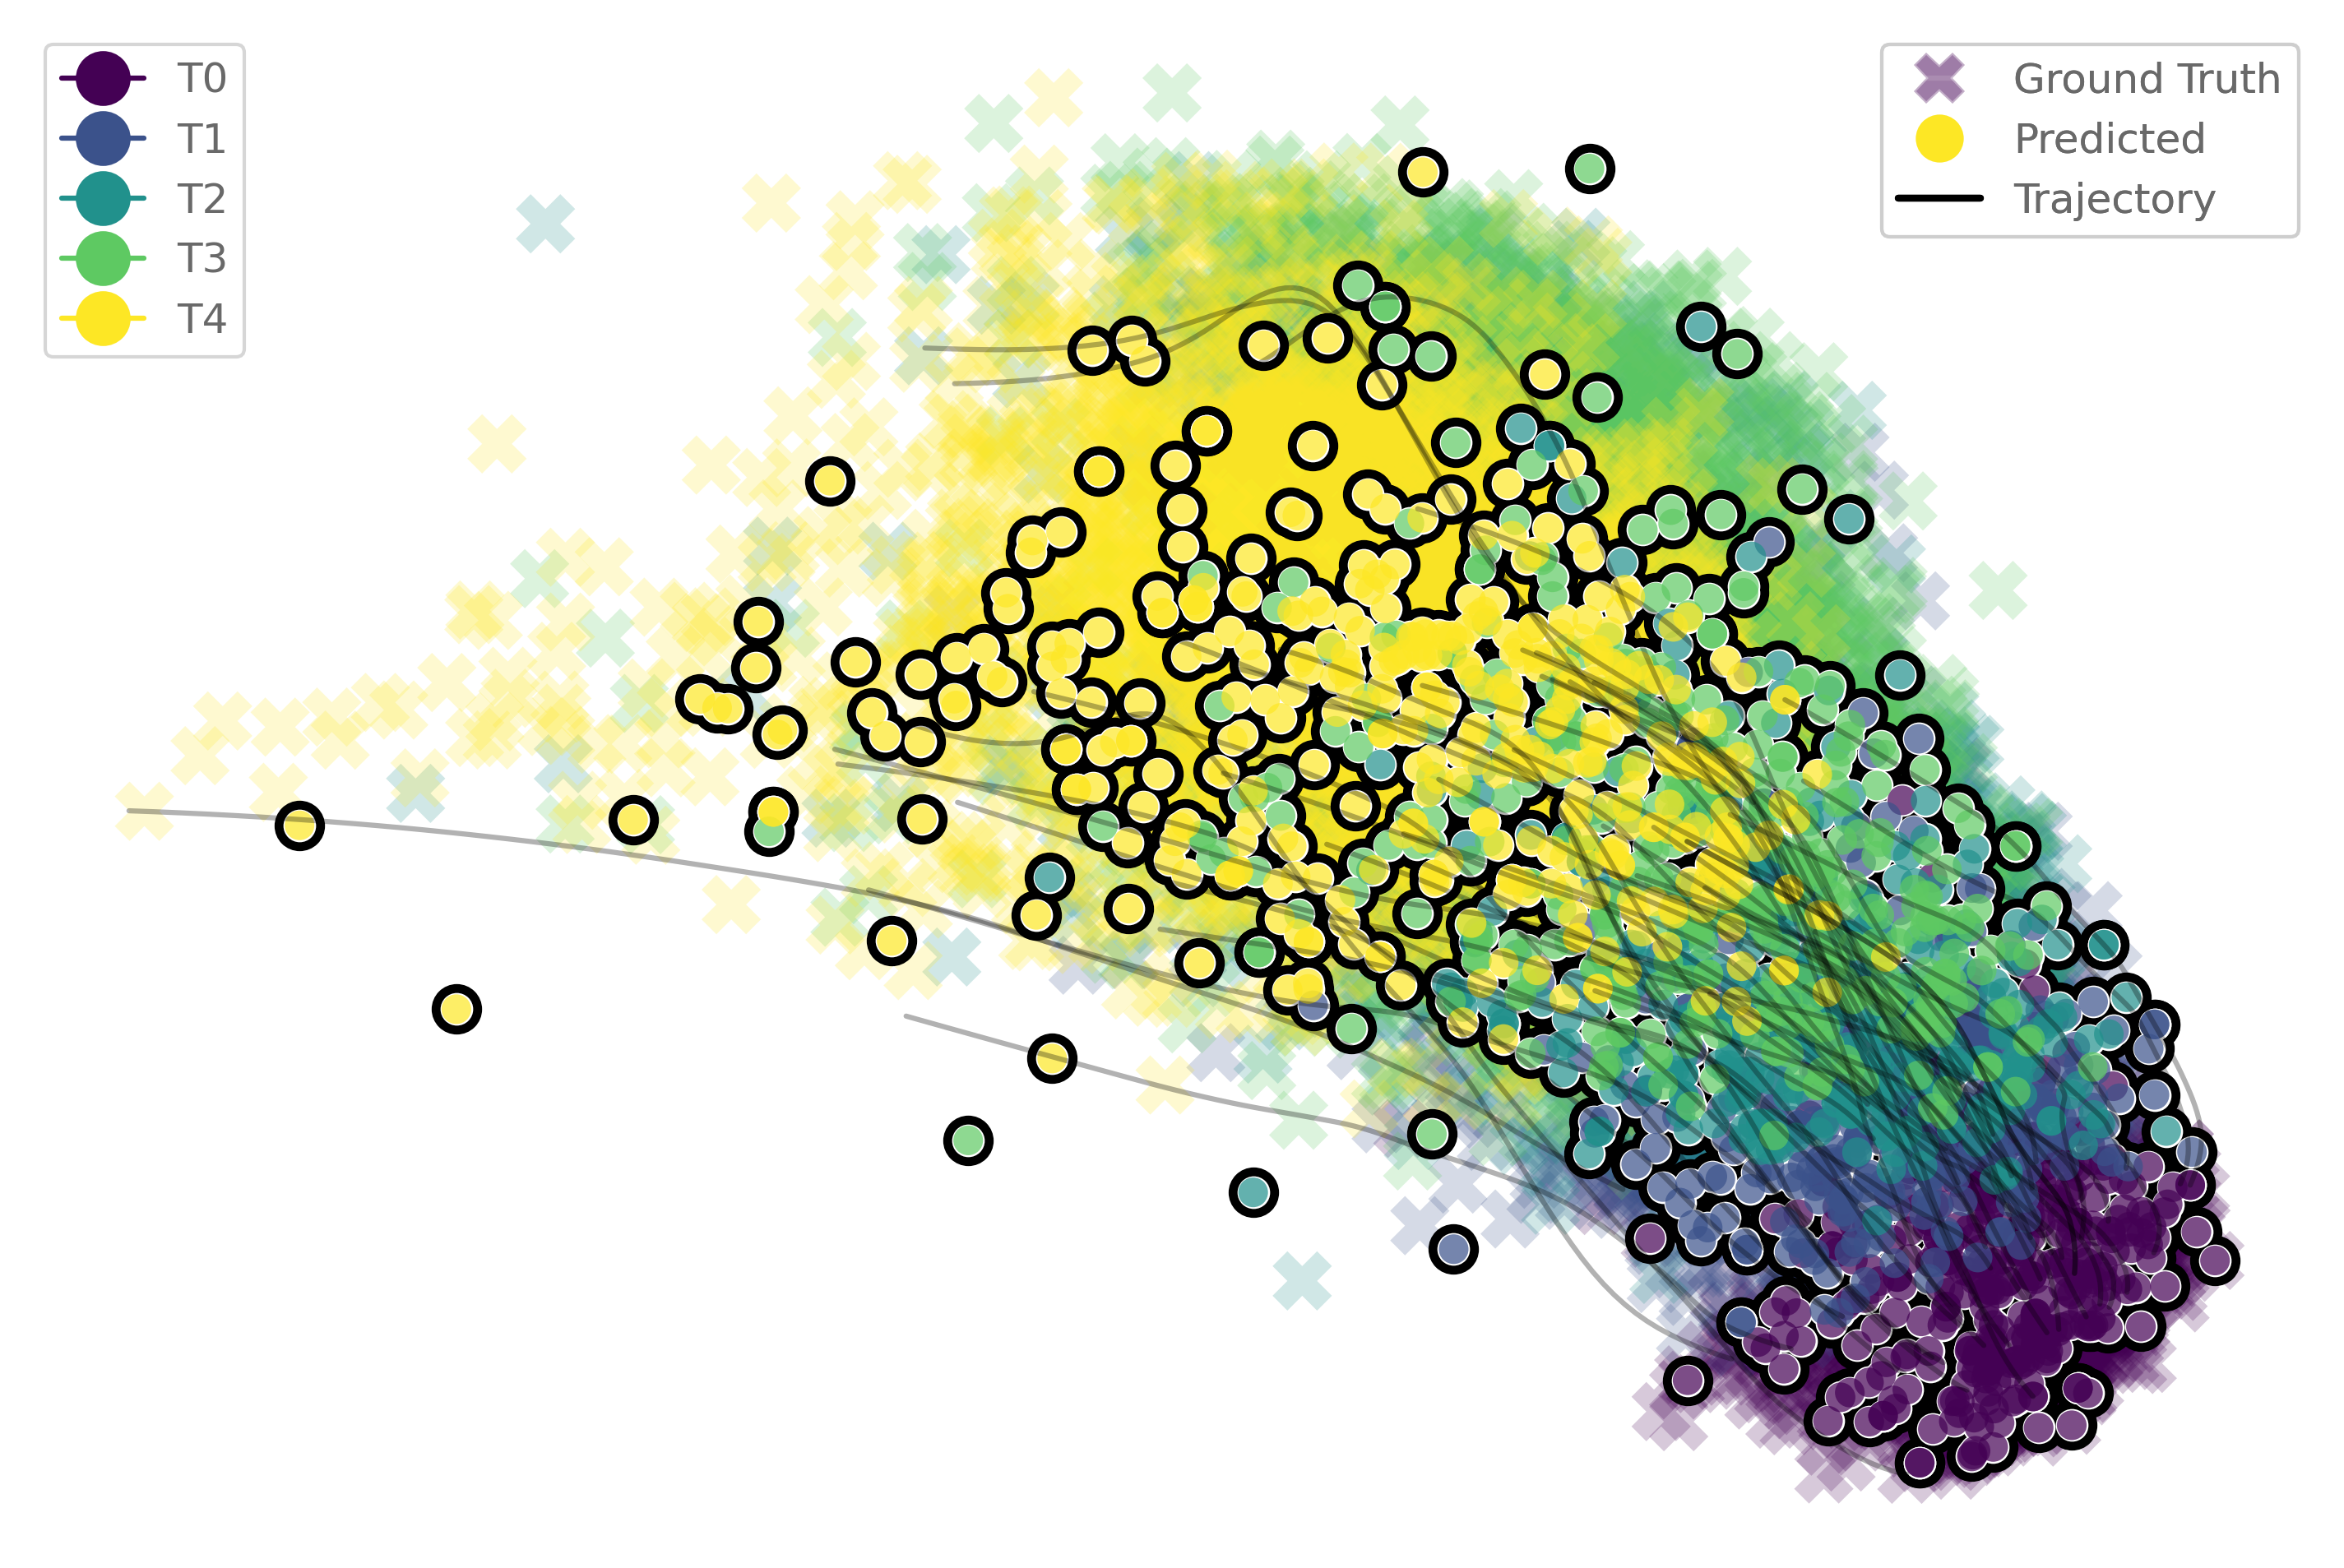

In [56]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='comparision_pretrain.png',
    x='x1', y='x2', is_3d=False
)

### Incorporating $\mathcal{L}_{\rm OT}$

Note: below, `relative_mass_now` is also displayed at the hold-out time points, which may cause a mismatch with `relative_mass_pred`. Please manually align the predicted and ground-truth time points when comparing them.

In [57]:
logger.info("Incorporating $L_{ot}$")

l_loss, b_loss, g_loss = train(
    f_net,
    df,
    groups,
    optimizer,
    args.epochs2,  # n_epoch
    criterion=criterion,
    use_cuda=use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=args.hold_one_out,
    hold_out=args.hold_out,
    sample_size=sample_size,
    relative_mass=relative_mass,
    initial_size=initial_size,
    sample_with_replacement=args.sample_with_replacement,
    logger=logger,
    device=device,
    best_model_path=exp_dir + "/best_model",
    stepsize=0.1,
)


for k, v in l_loss.items():
    local_losses[k].extend(v)

batch_losses.extend(b_loss)
globe_losses.extend(g_loss)


  0%|          | 0/30 [00:00<?, ?it/s]

[(0, 1), (1, 3), (3, 4)]
epoch_0_0:
relative_mass_pred:1.7315411567687988,relative_mass_now:1.7484250314993701
RME:0.00965661920093448
Otloss:0.585328
total loss:0.585328
epoch_0_1:
relative_mass_pred:1.6647346019744873,relative_mass_now:1.376732465350693
RME:0.20919252205651448
Otloss:0.753339
total loss:0.753339
epoch_0_2:
relative_mass_pred:1.5166292190551758,relative_mass_now:1.5392692146157076
RME:0.014708275424181821


  3%|▎         | 1/30 [00:03<01:54,  3.96s/it]

Otloss:0.809955
total loss:0.809955
New minimum otloss found: 0.8099554777145386. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_1_0:
relative_mass_pred:1.7266497611999512,relative_mass_now:1.7484250314993701
RME:0.012454220173652776
Otloss:0.540472
total loss:0.540472
epoch_1_1:
relative_mass_pred:1.6367707252502441,relative_mass_now:1.376732465350693
RME:0.18888074948774602
Otloss:0.635231
total loss:0.635231
epoch_1_2:
relative_mass_pred:1.4892035722732544,relative_mass_now:1.5392692146157076
RME:0.03252559192834412


  7%|▋         | 2/30 [00:07<01:48,  3.88s/it]

Otloss:0.700496
total loss:0.700496
New minimum otloss found: 0.7004964351654053. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_2_0:
relative_mass_pred:1.7221412658691406,relative_mass_now:1.7484250314993701
RME:0.015032823916785112
Otloss:0.515125
total loss:0.515125
epoch_2_1:
relative_mass_pred:1.6142308712005615,relative_mass_now:1.376732465350693
RME:0.17250875665910223
Otloss:0.597325
total loss:0.597325
epoch_2_2:
relative_mass_pred:1.4673793315887451,relative_mass_now:1.5392692146157076
RME:0.04670390490783023


 10%|█         | 3/30 [00:11<01:43,  3.82s/it]

Otloss:0.669102
total loss:0.669102
New minimum otloss found: 0.6691024303436279. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_3_0:
relative_mass_pred:1.718434453010559,relative_mass_now:1.7484250314993701
RME:0.0171529107330913
Otloss:0.496718
total loss:0.496718
epoch_3_1:
relative_mass_pred:1.5978074073791504,relative_mass_now:1.376732465350693
RME:0.1605794499602676
Otloss:0.604832
total loss:0.604832
epoch_3_2:
relative_mass_pred:1.4518563747406006,relative_mass_now:1.5392692146157076
RME:0.056788532535506114


 13%|█▎        | 4/30 [00:15<01:38,  3.78s/it]

Otloss:0.668957
total loss:0.668957
New minimum otloss found: 0.6689567565917969. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_4_0:
relative_mass_pred:1.7161730527877808,relative_mass_now:1.7484250314993701
RME:0.018446303461997177
Otloss:0.480681
total loss:0.480681
epoch_4_1:
relative_mass_pred:1.5884947776794434,relative_mass_now:1.376732465350693
RME:0.15381515120645356
Otloss:0.60649
total loss:0.60649
epoch_4_2:
relative_mass_pred:1.4433531761169434,relative_mass_now:1.5392692146157076
RME:0.062312711504927086


 17%|█▋        | 5/30 [00:19<01:34,  3.77s/it]

Otloss:0.659466
total loss:0.659466
New minimum otloss found: 0.6594659686088562. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_5_0:
relative_mass_pred:1.7153387069702148,relative_mass_now:1.7484250314993701
RME:0.018923501970674682
Otloss:0.467154
total loss:0.467154
epoch_5_1:
relative_mass_pred:1.5851457118988037,relative_mass_now:1.376732465350693
RME:0.15138253204119945
Otloss:0.600473
total loss:0.600473
epoch_5_2:
relative_mass_pred:1.44051194190979,relative_mass_now:1.5392692146157076
RME:0.06415854469653201


 20%|██        | 6/30 [00:22<01:29,  3.75s/it]

Otloss:0.635124
total loss:0.635124
New minimum otloss found: 0.6351243257522583. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_6_0:
relative_mass_pred:1.7154366970062256,relative_mass_now:1.7484250314993701
RME:0.018867457225120617
Otloss:0.45777
total loss:0.45777
epoch_6_1:
relative_mass_pred:1.5853246450424194,relative_mass_now:1.376732465350693
RME:0.1515125014783407
Otloss:0.596954
total loss:0.596954
epoch_6_2:
relative_mass_pred:1.4408669471740723,relative_mass_now:1.5392692146157076
RME:0.06392791235430664


 23%|██▎       | 7/30 [00:26<01:25,  3.71s/it]

Otloss:0.605691
total loss:0.605691
New minimum otloss found: 0.6056910753250122. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_7_0:
relative_mass_pred:1.7158496379852295,relative_mass_now:1.7484250314993701
RME:0.01863127839470786
Otloss:0.451868
total loss:0.451868
epoch_7_1:
relative_mass_pred:1.5863374471664429,relative_mass_now:1.376732465350693
RME:0.15224815793267255
Otloss:0.592311
total loss:0.592311
epoch_7_2:
relative_mass_pred:1.4418481588363647,relative_mass_now:1.5392692146157076
RME:0.06329045942990871


 27%|██▋       | 8/30 [00:30<01:21,  3.70s/it]

Otloss:0.582076
total loss:0.582076
New minimum otloss found: 0.5820762515068054. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_8_0:
relative_mass_pred:1.7161283493041992,relative_mass_now:1.7484250314993701
RME:0.018471871320370384
Otloss:0.447386
total loss:0.447386
epoch_8_1:
relative_mass_pred:1.586350679397583,relative_mass_now:1.376732465350693
RME:0.15225776926346715
Otloss:0.579815
total loss:0.579815
epoch_8_2:
relative_mass_pred:1.441776990890503,relative_mass_now:1.5392692146157076
RME:0.06333669432188607


 30%|███       | 9/30 [00:33<01:17,  3.68s/it]

Otloss:0.569979
total loss:0.569979
New minimum otloss found: 0.5699788331985474. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_9_0:
relative_mass_pred:1.7161141633987427,relative_mass_now:1.7484250314993701
RME:0.018479984854094147
Otloss:0.443366
total loss:0.443366
epoch_9_1:
relative_mass_pred:1.5848714113235474,relative_mass_now:1.376732465350693
RME:0.15118329175148457
Otloss:0.562486
total loss:0.562486
epoch_9_2:
relative_mass_pred:1.4402601718902588,relative_mass_now:1.5392692146157076
RME:0.06432210933950716


 33%|███▎      | 10/30 [00:37<01:12,  3.65s/it]

Otloss:0.569031
total loss:0.569031
New minimum otloss found: 0.5690314173698425. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_10_0:
relative_mass_pred:1.7158987522125244,relative_mass_now:1.7484250314993701
RME:0.018603187840975168
Otloss:0.439983
total loss:0.439983
epoch_10_1:
relative_mass_pred:1.5825223922729492,relative_mass_now:1.376732465350693
RME:0.14947706406403058
Otloss:0.54872
total loss:0.54872
epoch_10_2:
relative_mass_pred:1.4379596710205078,relative_mass_now:1.5392692146157076
RME:0.06581665028654046


 37%|███▋      | 11/30 [00:40<01:08,  3.61s/it]

Otloss:0.572856
total loss:0.572856
[(0, 1), (1, 3), (3, 4)]
epoch_11_0:
relative_mass_pred:1.715700626373291,relative_mass_now:1.7484250314993701
RME:0.018716504589285213
Otloss:0.437086
total loss:0.437086
epoch_11_1:
relative_mass_pred:1.5804190635681152,relative_mass_now:1.376732465350693
RME:0.14794929541051938
Otloss:0.541107
total loss:0.541107
epoch_11_2:
relative_mass_pred:1.4359943866729736,relative_mass_now:1.5392692146157076
RME:0.06709341482446103


 40%|████      | 12/30 [00:44<01:04,  3.60s/it]

Otloss:0.57153
total loss:0.57153
[(0, 1), (1, 3), (3, 4)]
epoch_12_0:
relative_mass_pred:1.7156774997711182,relative_mass_now:1.7484250314993701
RME:0.01872973169468362
Otloss:0.434072
total loss:0.434072
epoch_12_1:
relative_mass_pred:1.5793429613113403,relative_mass_now:1.376732465350693
RME:0.14716766042779178
Otloss:0.535269
total loss:0.535269
epoch_12_2:
relative_mass_pred:1.4351160526275635,relative_mass_now:1.5392692146157076
RME:0.06766403238574932


 43%|████▎     | 13/30 [00:47<01:00,  3.59s/it]

Otloss:0.561776
total loss:0.561776
New minimum otloss found: 0.5617762804031372. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_13_0:
relative_mass_pred:1.7158068418502808,relative_mass_now:1.7484250314993701
RME:0.018655755357790477
Otloss:0.431034
total loss:0.431034
epoch_13_1:
relative_mass_pred:1.5792443752288818,relative_mass_now:1.376732465350693
RME:0.1470960516839438
Otloss:0.530782
total loss:0.530782
epoch_13_2:
relative_mass_pred:1.435215950012207,relative_mass_now:1.5392692146157076
RME:0.06759913315714461


 47%|████▋     | 14/30 [00:51<00:56,  3.55s/it]

Otloss:0.551003
total loss:0.551003
New minimum otloss found: 0.5510032176971436. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_14_0:
relative_mass_pred:1.7159030437469482,relative_mass_now:1.7484250314993701
RME:0.01860073332657134
Otloss:0.428483
total loss:0.428483
epoch_14_1:
relative_mass_pred:1.5793366432189941,relative_mass_now:1.376732465350693
RME:0.14716307123380878
Otloss:0.528855
total loss:0.528855
epoch_14_2:
relative_mass_pred:1.435441255569458,relative_mass_now:1.5392692146157076
RME:0.06745276138857309


 50%|█████     | 15/30 [00:54<00:53,  3.55s/it]

Otloss:0.54536
total loss:0.54536
New minimum otloss found: 0.54535973072052. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_15_0:
relative_mass_pred:1.7157847881317139,relative_mass_now:1.7484250314993701
RME:0.018668368834587924
Otloss:0.426299
total loss:0.426299
epoch_15_1:
relative_mass_pred:1.5787441730499268,relative_mass_now:1.376732465350693
RME:0.14673272606219517
Otloss:0.525835
total loss:0.525835
epoch_15_2:
relative_mass_pred:1.4348936080932617,relative_mass_now:1.5392692146157076
RME:0.06780854546519612


 53%|█████▎    | 16/30 [00:58<00:49,  3.53s/it]

Otloss:0.542382
total loss:0.542382
New minimum otloss found: 0.5423816442489624. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_16_0:
relative_mass_pred:1.7154560089111328,relative_mass_now:1.7484250314993701
RME:0.01885641191030339
Otloss:0.424206
total loss:0.424206
epoch_16_1:
relative_mass_pred:1.5772960186004639,relative_mass_now:1.376732465350693
RME:0.14568084816586474
Otloss:0.520437
total loss:0.520437
epoch_16_2:
relative_mass_pred:1.4334385395050049,relative_mass_now:1.5392692146157076
RME:0.06875384377587539


 57%|█████▋    | 17/30 [01:01<00:45,  3.51s/it]

Otloss:0.541092
total loss:0.541092
New minimum otloss found: 0.5410915613174438. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_17_0:
relative_mass_pred:1.7151284217834473,relative_mass_now:1.7484250314993701
RME:0.01904377317646224
Otloss:0.422314
total loss:0.422314
epoch_17_1:
relative_mass_pred:1.5756969451904297,relative_mass_now:1.376732465350693
RME:0.14451934914533657
Otloss:0.516324
total loss:0.516324
epoch_17_2:
relative_mass_pred:1.4318361282348633,relative_mass_now:1.5392692146157076
RME:0.06979486457647761


 60%|██████    | 18/30 [01:05<00:41,  3.48s/it]

Otloss:0.541238
total loss:0.541238
[(0, 1), (1, 3), (3, 4)]
epoch_18_0:
relative_mass_pred:1.715061068534851,relative_mass_now:1.7484250314993701
RME:0.019082295416411203
Otloss:0.420614
total loss:0.420614
epoch_18_1:
relative_mass_pred:1.5749268531799316,relative_mass_now:1.376732465350693
RME:0.14395998701080456
Otloss:0.514191
total loss:0.514191
epoch_18_2:
relative_mass_pred:1.4310972690582275,relative_mass_now:1.5392692146157076
RME:0.07027487104293592


 63%|██████▎   | 19/30 [01:08<00:38,  3.47s/it]

Otloss:0.53844
total loss:0.53844
New minimum otloss found: 0.538440465927124. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_19_0:
relative_mass_pred:1.7153431177139282,relative_mass_now:1.7484250314993701
RME:0.018920979275315195
Otloss:0.418957
total loss:0.418957
epoch_19_1:
relative_mass_pred:1.5753974914550781,relative_mass_now:1.376732465350693
RME:0.14430183866825538
Otloss:0.511912
total loss:0.511912
epoch_19_2:
relative_mass_pred:1.4316306114196777,relative_mass_now:1.5392692146157076
RME:0.06992838041193648


 67%|██████▋   | 20/30 [01:12<00:34,  3.46s/it]

Otloss:0.531734
total loss:0.531734
New minimum otloss found: 0.5317338705062866. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_20_0:
relative_mass_pred:1.7157995700836182,relative_mass_now:1.7484250314993701
RME:0.01865991439608585
Otloss:0.417498
total loss:0.417498
epoch_20_1:
relative_mass_pred:1.5765842199325562,relative_mass_now:1.376732465350693
RME:0.14516382783996837
Otloss:0.510032
total loss:0.510032
epoch_20_2:
relative_mass_pred:1.4328839778900146,relative_mass_now:1.5392692146157076
RME:0.06911411968454981


 70%|███████   | 21/30 [01:15<00:30,  3.43s/it]

Otloss:0.526479
total loss:0.526479
New minimum otloss found: 0.5264794826507568. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_21_0:
relative_mass_pred:1.716116189956665,relative_mass_now:1.7484250314993701
RME:0.018478825777847895
Otloss:0.416254
total loss:0.416254
epoch_21_1:
relative_mass_pred:1.5774025917053223,relative_mass_now:1.376732465350693
RME:0.14575825834361575
Otloss:0.508636
total loss:0.508636
epoch_21_2:
relative_mass_pred:1.4337449073791504,relative_mass_now:1.5392692146157076
RME:0.06855480914877021


 73%|███████▎  | 22/30 [01:18<00:27,  3.42s/it]

Otloss:0.524361
total loss:0.524361
New minimum otloss found: 0.5243611931800842. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_22_0:
relative_mass_pred:1.7161006927490234,relative_mass_now:1.7484250314993701
RME:0.01848768930208394
Otloss:0.414953
total loss:0.414953
epoch_22_1:
relative_mass_pred:1.5771223306655884,relative_mass_now:1.376732465350693
RME:0.14555468862561502
Otloss:0.505912
total loss:0.505912
epoch_22_2:
relative_mass_pred:1.433478593826294,relative_mass_now:1.5392692146157076
RME:0.06872782212812933


 77%|███████▋  | 23/30 [01:22<00:23,  3.39s/it]

Otloss:0.522737
total loss:0.522737
New minimum otloss found: 0.5227372050285339. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_23_0:
relative_mass_pred:1.7158398628234863,relative_mass_now:1.7484250314993701
RME:0.018636869233072135
Otloss:0.413711
total loss:0.413711
epoch_23_1:
relative_mass_pred:1.5760080814361572,relative_mass_now:1.376732465350693
RME:0.14474534530185798
Otloss:0.503085
total loss:0.503085
epoch_23_2:
relative_mass_pred:1.4323747158050537,relative_mass_now:1.5392692146157076
RME:0.06944496634874953


 80%|████████  | 24/30 [01:25<00:20,  3.39s/it]

Otloss:0.52218
total loss:0.52218
New minimum otloss found: 0.5221801400184631. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_24_0:
relative_mass_pred:1.7156250476837158,relative_mass_now:1.7484250314993701
RME:0.018759731315174846
Otloss:0.412664
total loss:0.412664
epoch_24_1:
relative_mass_pred:1.5750566720962524,relative_mass_now:1.376732465350693
RME:0.1440542819588704
Otloss:0.50147
total loss:0.50147
epoch_24_2:
relative_mass_pred:1.431453824043274,relative_mass_now:1.5392692146157076
RME:0.070043231910768


 83%|████████▎ | 25/30 [01:28<00:16,  3.39s/it]

Otloss:0.522114
total loss:0.522114
New minimum otloss found: 0.5221139788627625. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_25_0:
relative_mass_pred:1.715693473815918,relative_mass_now:1.7484250314993701
RME:0.018720595446624924
Otloss:0.411569
total loss:0.411569
epoch_25_1:
relative_mass_pred:1.5750731229782104,relative_mass_now:1.376732465350693
RME:0.14406623118093936
Otloss:0.499823
total loss:0.499823
epoch_25_2:
relative_mass_pred:1.4315156936645508,relative_mass_now:1.5392692146157076
RME:0.07000303775844598


 87%|████████▋ | 26/30 [01:32<00:13,  3.35s/it]

Otloss:0.520074
total loss:0.520074
New minimum otloss found: 0.5200740694999695. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_26_0:
relative_mass_pred:1.7160019874572754,relative_mass_now:1.7484250314993701
RME:0.01854414313337198
Otloss:0.41043
total loss:0.41043
epoch_26_1:
relative_mass_pred:1.5759024620056152,relative_mass_now:1.376732465350693
RME:0.1446686278326327
Otloss:0.498344
total loss:0.498344
epoch_26_2:
relative_mass_pred:1.432385802268982,relative_mass_now:1.5392692146157076
RME:0.06943776392839125


 90%|█████████ | 27/30 [01:35<00:10,  3.35s/it]

Otloss:0.517601
total loss:0.517601
New minimum otloss found: 0.5176008939743042. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_27_0:
relative_mass_pred:1.7162944078445435,relative_mass_now:1.7484250314993701
RME:0.018376895249133385
Otloss:0.409409
total loss:0.409409
epoch_27_1:
relative_mass_pred:1.5766689777374268,relative_mass_now:1.376732465350693
RME:0.14522539231019319
Otloss:0.497407
total loss:0.497407
epoch_27_2:
relative_mass_pred:1.4331669807434082,relative_mass_now:1.5392692146157076
RME:0.06893026435196316


 93%|█████████▎| 28/30 [01:38<00:06,  3.35s/it]

Otloss:0.516368
total loss:0.516368
New minimum otloss found: 0.5163684487342834. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_28_0:
relative_mass_pred:1.716360330581665,relative_mass_now:1.7484250314993701
RME:0.018339191180652362
Otloss:0.408418
total loss:0.408418
epoch_28_1:
relative_mass_pred:1.576675534248352,relative_mass_now:1.376732465350693
RME:0.14523015468130762
Otloss:0.495973
total loss:0.495973
epoch_28_2:
relative_mass_pred:1.433158040046692,relative_mass_now:1.5392692146157076
RME:0.0689360727554779


 97%|█████████▋| 29/30 [01:42<00:03,  3.35s/it]

Otloss:0.515044
total loss:0.515044
New minimum otloss found: 0.5150437355041504. Model saved.
[(0, 1), (1, 3), (3, 4)]
epoch_29_0:
relative_mass_pred:1.7162206172943115,relative_mass_now:1.7484250314993701
RME:0.018419099260688087
Otloss:0.407456
total loss:0.407456
epoch_29_1:
relative_mass_pred:1.5760471820831299,relative_mass_now:1.376732465350693
RME:0.14477374635141319
Otloss:0.494462
total loss:0.494462
epoch_29_2:
relative_mass_pred:1.4325034618377686,relative_mass_now:1.5392692146157076
RME:0.06936132533813724


100%|██████████| 30/30 [01:45<00:00,  3.52s/it]

Otloss:0.51408
total loss:0.51408
New minimum otloss found: 0.5140799283981323. Model saved.


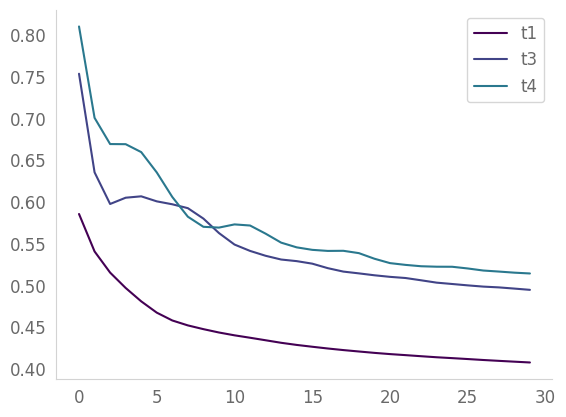

In [58]:
import os
import matplotlib.pyplot as plt

# 假设你已有变量：l_loss 和 exp_dir
plt.plot(l_loss['0:1'], label='t1')
plt.plot(l_loss['1:3'], label='t3')
plt.plot(l_loss['3:4'], label='t4')
plt.legend()

# 拼接保存路径
save_path = os.path.join(exp_dir, 'emd_train_each_tp.png')
plt.savefig(save_path)

### Test

In [59]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/best_model'),map_location=torch.device('cpu')))

<All keys matched successfully>

In [60]:
groups =[0,1,2,3,4]

For simplicity, we present the prediction results using function `train` by setting `epoch=1`, `hold_one_out=False` and `hold_out=-1`, one just need to focus on the **hold-out** time points.  
For example, if the hold-out time point is **n**, then the **OT loss of `epoch0_{n-1}`** corresponds to the **EMD at the hold-out time point**.


In [61]:
logger.info("Testing on held out time point")
l_loss, b_loss, g_loss = train(
    f_net, df, groups, optimizer, 1, 
    criterion = criterion, use_cuda = use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=False, hold_out=-1, 
    sample_size = sample_size,relative_mass=relative_mass,initial_size=initial_size,
    sample_with_replacement = args.sample_with_replacement, logger=logger, device=device, best_model_path=exp_dir+'/test_model',stepsize=0.1
)

  0%|          | 0/1 [00:00<?, ?it/s]

epoch_0_0:
relative_mass_pred:1.7160816192626953,relative_mass_now:1.7484250314993701
RME:0.01849859825498984
Otloss:0.406559
total loss:0.406559
epoch_0_1:
relative_mass_pred:1.6872503757476807,relative_mass_now:1.376732465350693
RME:0.2255470239948834
Otloss:0.757517
total loss:0.757517
epoch_0_2:
relative_mass_pred:1.575486660003662,relative_mass_now:1.5392692146157076
RME:0.02352898703102853
Otloss:0.493455
total loss:0.493455
epoch_0_3:
relative_mass_pred:1.4318959712982178,relative_mass_now:1.3994120117597648
RME:0.023212577329248644


100%|██████████| 1/1 [00:04<00:00,  4.44s/it]

Otloss:0.514122
total loss:0.514122
New minimum otloss found: 0.5141220688819885. Model saved.


In [62]:
# generate plot data
f_net.to('cpu')
generated, trajectories,generated_weights,trajectories_weights = generate_plot_data(
    f_net, df, n_points=400, n_trajectories=50, n_bins=100, 
    sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1., 2., 3., 4.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0404, 0.0808, 0.1212, 0.1616, 0.2020, 0.2424, 0.2828, 0.3232,
        0.3636, 0.4040, 0.4444, 0.4848, 0.5253, 0.5657, 0.6061, 0.6465, 0.6869,
        0.7273, 0.7677, 0.8081, 0.8485, 0.8889, 0.9293, 0.9697, 1.0101, 1.0505,
        1.0909, 1.1313, 1.1717, 1.2121, 1.2525, 1.2929, 1.3333, 1.3737, 1.4141,
        1.4545, 1.4949, 1.5354, 1.5758, 1.6162, 1.6566, 1.6970, 1.7374, 1.7778,
        1.8182, 1.8586, 1.8990, 1.9394, 1.9798, 2.0202, 2.0606, 2.1010, 2.1414,
        2.1818, 2.2222, 2.2626, 2.3030, 2.3434, 2.3838, 2.4242, 2.4646, 2.5051,
        2.5455, 2.5859, 2.6263, 2.6667, 2.7071, 2.7475, 2.7879, 2.8283, 2.8687,
        2.9091, 2.9495, 2.9899, 3.0303, 3.0707, 3.1111, 3.1515, 3.1919, 3.2323,
        3.2727, 3.3131, 3.3535, 3.3939, 3.4343, 3.4747, 3.5152, 3.5556, 3.5960,
        3.6364, 3.6768, 3.7172, 3.7576, 3.7980, 3.8384, 3.8788, 3.9192, 3.9596,
        4.0000])
<class 'torch.Tensor'>


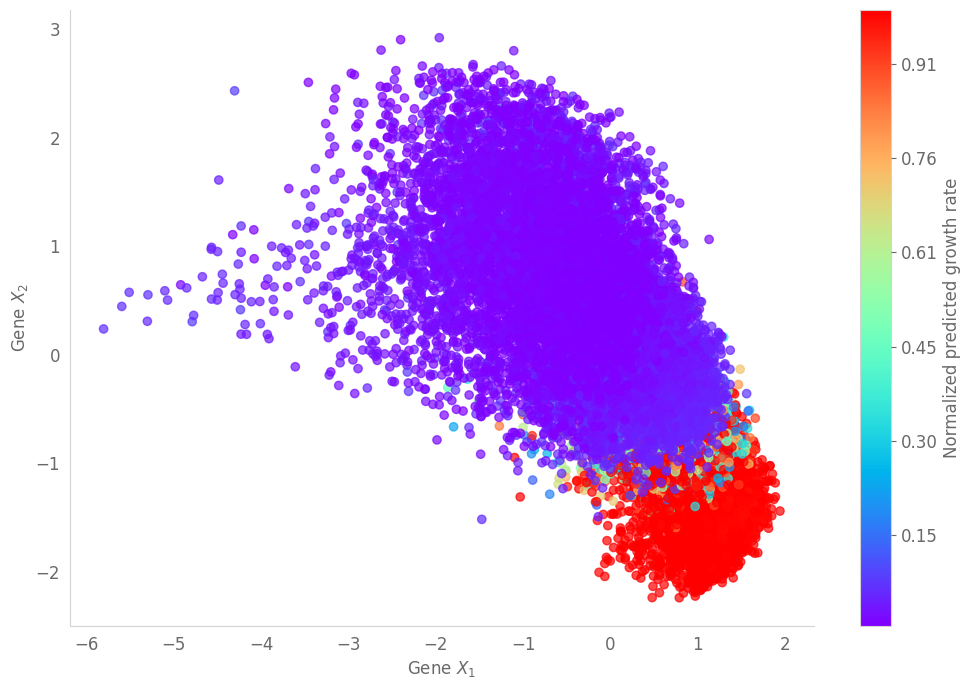

In [63]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        n = 5

        column_names = [f'x{i}' for i in range(1, n + 1)]

        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]

        data = torch.stack(tensors, dim=1)
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g= f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 90)
    vmin_value = np.percentile(all_g_values, 10)
    
    norm = plt.Normalize(vmin=vmin_value, vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_final.pdf')

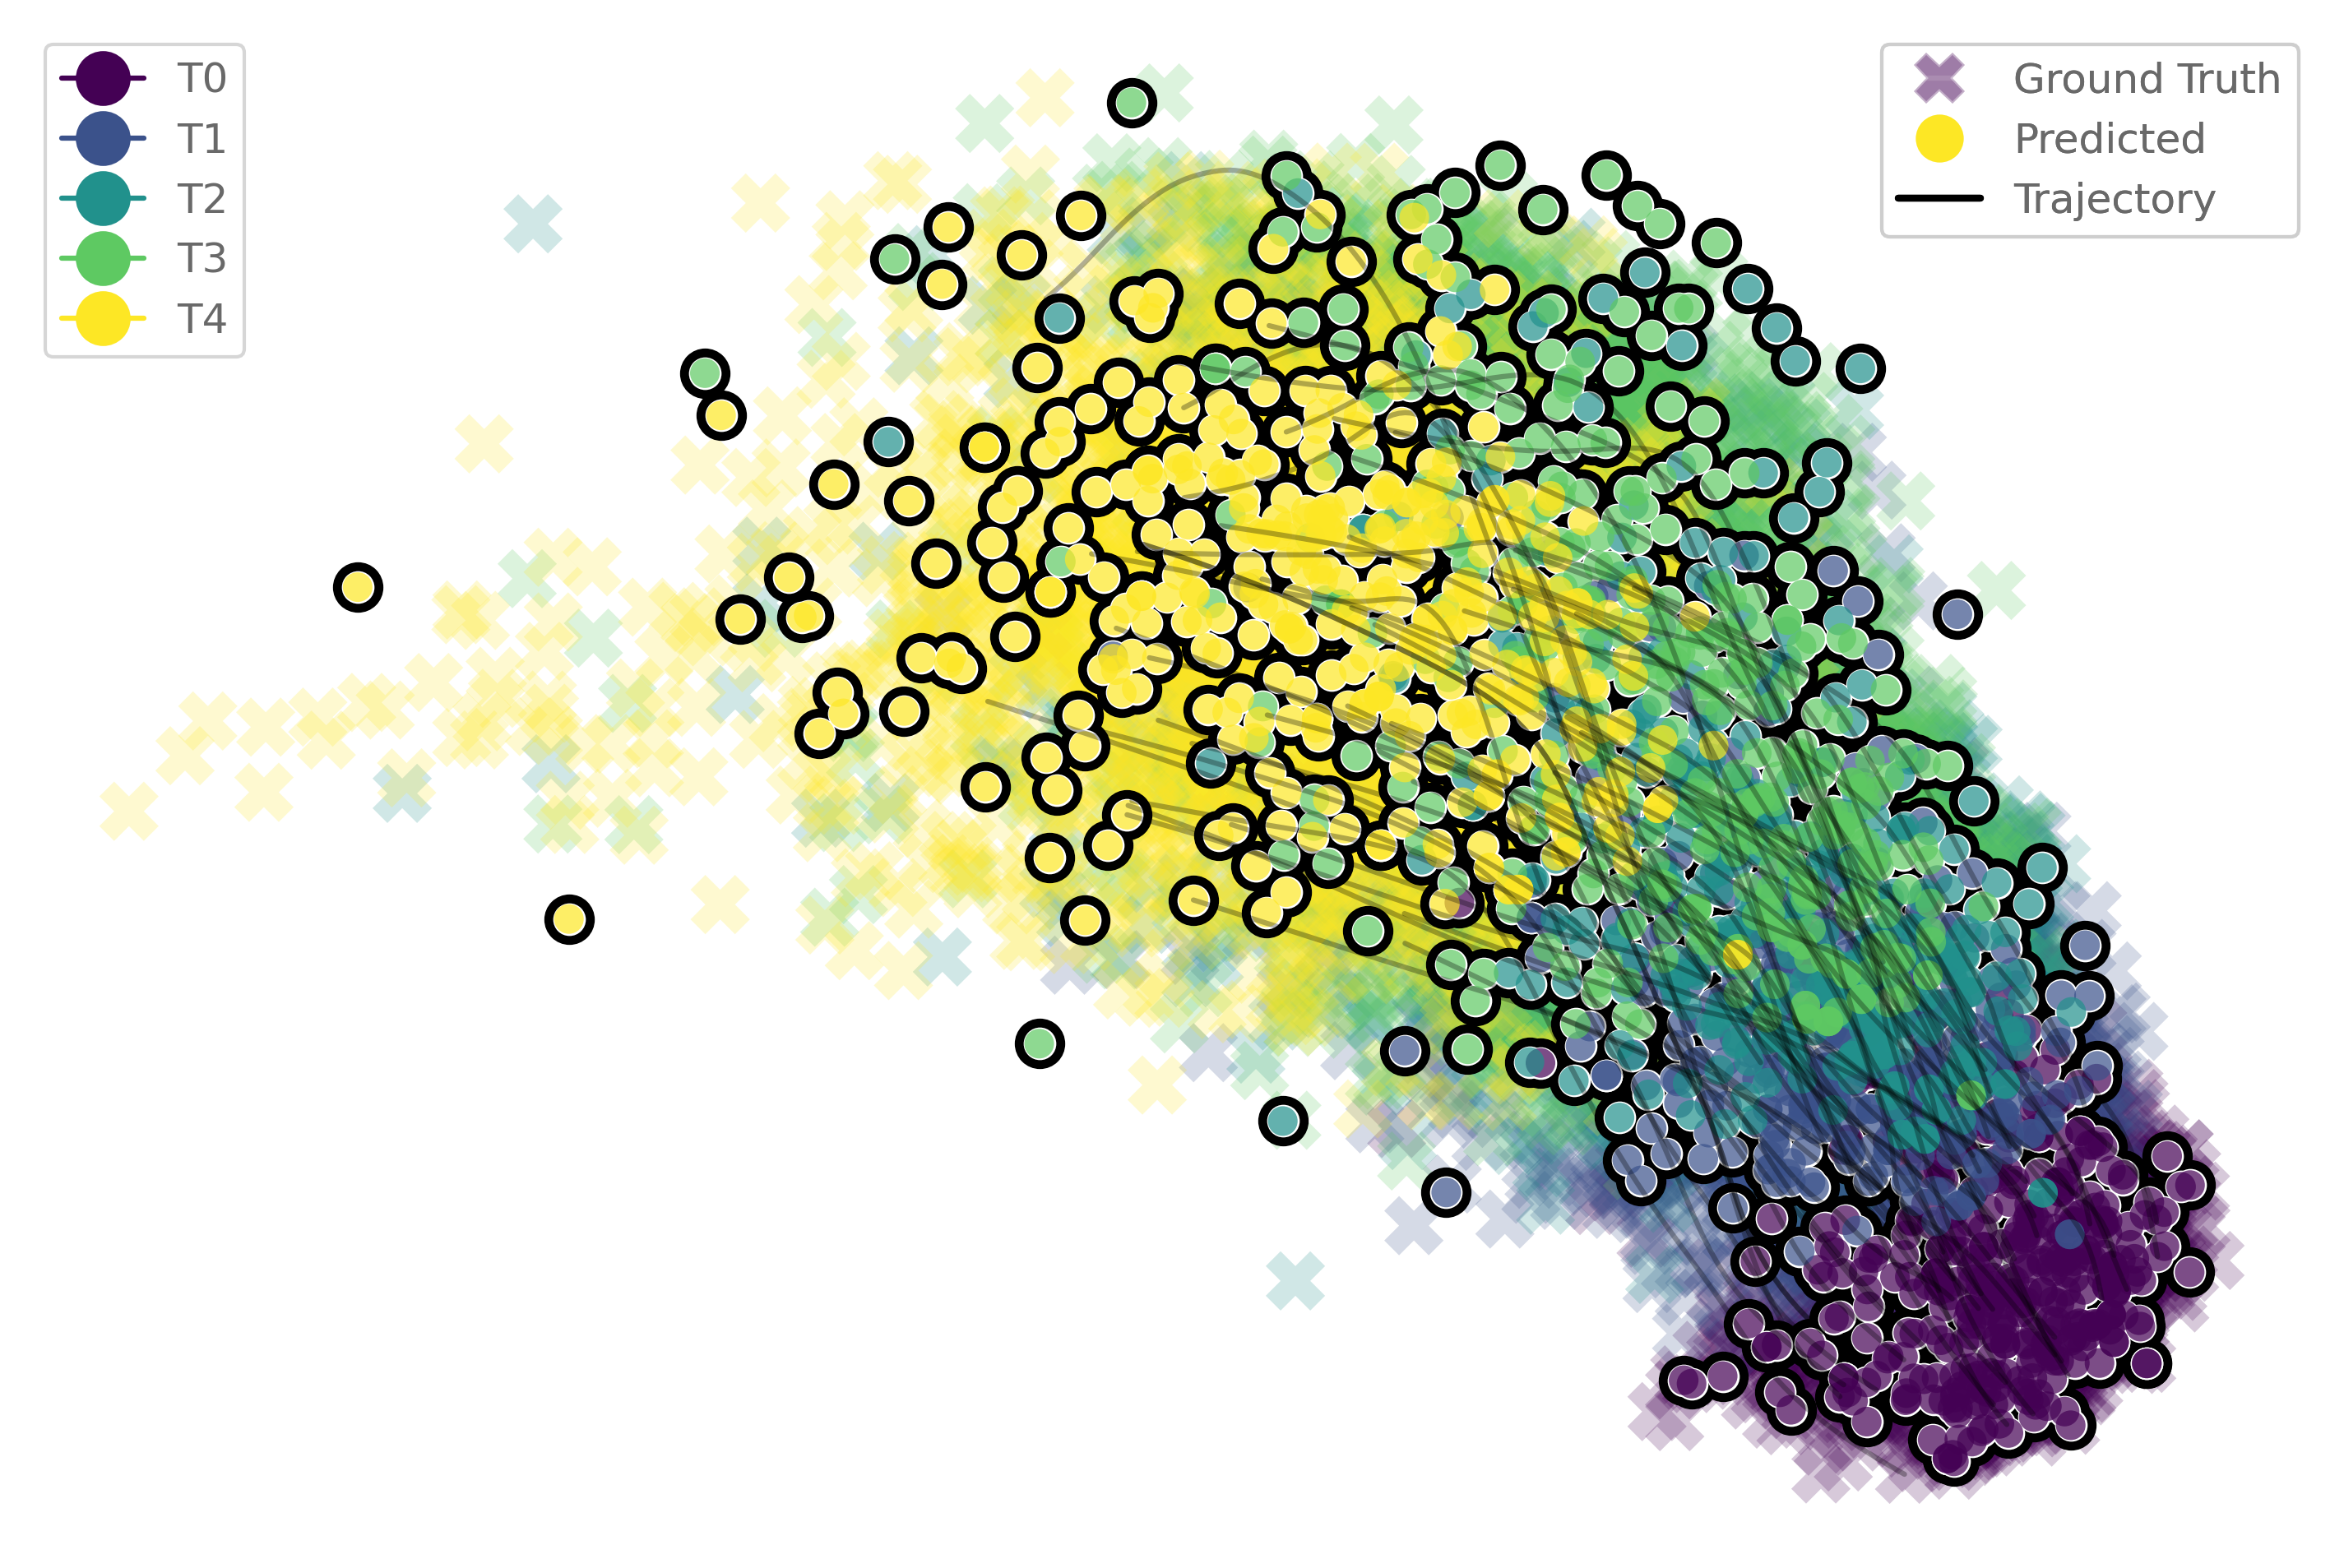

In [64]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='comparision_final.png',
    x='x1', y='x2', is_3d=False
)